In [ ]:
import wfdb
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

# Signal preprocessing
def bandpass_filter(signal, fs, lowcut=0.5, highcut=50, order=2):
    nyquist = 0.5 * fs
    if highcut >= nyquist:
        highcut = nyquist - 0.1
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
    nyquist = 0.5 * fs
    notch = notch_freq / nyquist
    if notch >= 1.0:
        return signal
    b, a = iirnotch(notch, quality_factor)
    return filtfilt(b, a, signal)

def preprocess_signal(signal, fs):
    signal = bandpass_filter(signal, fs)
    signal = notch_filter(signal, fs)
    return signal

def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))


def processing_data(file_name):

    #acquire RCG & PPG signal
    record_ecg = wfdb.rdrecord(f'./training_data/{file_name}/{file_name}_ECG')
    ecg_signal = record_ecg.p_signal[:, 0]
    fs_ecg = record_ecg.fs
    ecg_signal = preprocess_signal(ecg_signal, fs_ecg)

    record_ppg = wfdb.rdrecord(f'./training_data/{file_name}/{file_name}_PPG')
    ppg_signal = record_ppg.p_signal[:, 0]
    fs_ppg = record_ppg.fs
    ppg_signal = preprocess_signal(ppg_signal, fs_ppg)

    # Normalizing
    if fs_ecg != fs_ppg:
        time_ppg = np.arange(0, len(ppg_signal)) / fs_ppg
        time_ecg = np.arange(0, len(ecg_signal)) / fs_ecg
        max_time = min(time_ppg[-1], time_ecg[-1])
        time_ppg = time_ppg[time_ppg <= max_time]
        time_ecg = time_ecg[time_ecg <= max_time]
        interp_func = interp1d(time_ppg, ppg_signal[:len(time_ppg)], kind='linear', fill_value='extrapolate')
        ppg_signal = interp_func(time_ecg)
        ecg_signal = ecg_signal[:len(ppg_signal)]
        fs = fs_ecg
    else:
        fs = fs_ecg

    normalized_ecg = normalize_signal(ecg_signal)
    normalized_ppg = normalize_signal(ppg_signal)

    # Signal fusion (simple averaging)
    fused_signal_avg = (normalized_ecg + normalized_ppg) / 2

    # Signal fusion (PCA fusion)
    data_matrix = np.vstack((normalized_ecg, normalized_ppg)).T
    pca = PCA(n_components=1)
    fused_signal_pca = pca.fit_transform(data_matrix).flatten()
    fused_signal_pca = normalize_signal(fused_signal_pca)

    # time_axis = np.arange(len(normalized_ecg)) / fs

    # plt.figure(figsize=(14, 8))
    # plt.plot(time_axis, normalized_ecg, label='Normalized ECG', alpha=0.7)
    # plt.plot(time_axis, normalized_ppg, label='Normalized PPG', alpha=0.7)
    # plt.plot(time_axis, fused_signal_avg, label='Fused Signal (Average)', linewidth=2)
    # plt.plot(time_axis, fused_signal_pca, label='Fused Signal (PCA)', linewidth=2, linestyle='--')
    # plt.title("ECG & PPG Fusion")
    # plt.xlabel("Time (s)")
    # plt.ylabel("Normalized Amplitude")
    # plt.legend()
    # plt.grid()

    # plt.savefig(f'./processed_data/{file_name}.png', dpi=300)
    # plt.show()

    np.savetxt(f"./processed_data/{file_name}.csv", fused_signal_avg, delimiter=",")

for index, file_name in tqdm(enumerate(os.listdir("./training_data"))):
    fused_signal_pca = processing_data(file_name)

print("Complete data preprocessing")

100it [00:01, 74.87it/s]

Complete data preprocessing


In [11]:
import numpy as np
import pandas as pd
import glob
from scipy.stats import kurtosis, skew

def extract_features_from_signal(signal):
    features = {}
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['min'] = np.min(signal)
    features['max'] = np.max(signal)
    features['skew'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)
    return features

all_features = []
all_labels = []

label_dict = {}
df_labels = pd.read_csv('./labels.csv')
for row in df_labels.itertuples():
    label_dict[str(row.filename)] = row.label

for filepath in glob.glob('./processed_data/*.csv'):
    filename = filepath.split('\\')[-1]
    signal = np.loadtxt(filepath, delimiter=',')

    features = extract_features_from_signal(signal)
    all_features.append(features)

    label = label_dict.get(filename[:-4], None)
    all_labels.append(label)

df_X = pd.DataFrame(all_features)
y = np.array(all_labels)

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
import joblib

X = df_X.values
y = y.values if hasattr(y, 'values') else y  

# 定義參數空間
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# 建立基礎模型
model = RandomForestClassifier(random_state=42)

# 設定 5 折交叉驗證
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 使用 GridSearchCV 進行超參數搜索
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kf,
    n_jobs=-1
)
grid_search.fit(X, y)

# 輸出最佳參數與交叉驗證分數
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# 取得並以全量資料進行重新訓練
best_model = grid_search.best_estimator_
best_model.fit(X, y)
print("Best model has been re-trained on the full dataset.")

# 儲存模型
joblib.dump(best_model, 'my_model.pkl')
print("Best model saved as my_model.pkl")

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best cross-validation accuracy: 0.72
Best model has been re-trained on the full dataset.
Best model saved as my_model.pkl


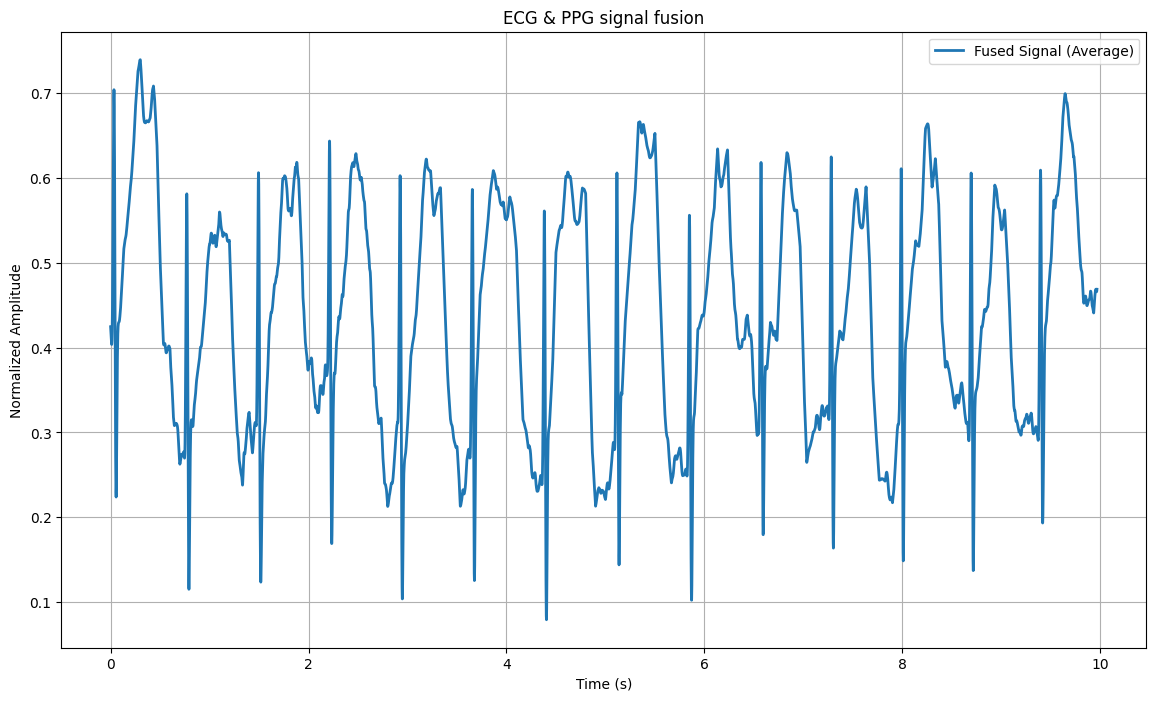

Prediction: [1]
Probabilities: [[0.3618557 0.6381443]]


In [16]:
import wfdb
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch
from scipy.interpolate import interp1d
from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA

# ----------------------- Preprocessing Function Definitions -----------------------
def bandpass_filter(signal, fs, lowcut=0.5, highcut=50, order=2):
  nyquist = 0.5 * fs
  if highcut >= nyquist:
      highcut = nyquist - 0.1
  low = lowcut / nyquist
  high = highcut / nyquist
  b, a = butter(order, [low, high], btype='band')
  return filtfilt(b, a, signal)

def notch_filter(signal, fs, notch_freq=50, quality_factor=30):
  nyquist = 0.5 * fs
  notch = notch_freq / nyquist
  if notch >= 1.0:
      return signal
  b, a = iirnotch(notch, quality_factor)
  return filtfilt(b, a, signal)

def preprocess_signal(signal, fs):
  signal = bandpass_filter(signal, fs)
  signal = notch_filter(signal, fs)
  return signal

def normalize_signal(signal):
  return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

def extract_features_from_signal(signal):
    """Extracts basic statistical features from a 1D time-series waveform and returns a fixed-length feature vector."""
    features = {}
    features['mean'] = np.mean(signal)
    features['std'] = np.std(signal)
    features['min'] = np.min(signal)
    features['max'] = np.max(signal)
    features['skew'] = skew(signal)
    features['kurtosis'] = kurtosis(signal)
    # Additional features can be added here
    return features

# ----------------------- Read and Preprocess Signals -----------------------
# Read ECG Signal

def processing_data(file_name):

  record_ecg = wfdb.rdrecord(f'./test_data/{file_name}/{file_name}_ECG')
  ecg_signal = record_ecg.p_signal[:, 0]
  fs_ecg = record_ecg.fs
  ecg_signal = preprocess_signal(ecg_signal, fs_ecg)

  # Read PPG Signal
  record_ppg = wfdb.rdrecord(f'./test_data/{file_name}/{file_name}_PPG')
  ppg_signal = record_ppg.p_signal[:, 0]
  fs_ppg = record_ppg.fs
  ppg_signal = preprocess_signal(ppg_signal, fs_ppg)

  # If the two signals have different sampling rates, perform time alignment (interpolation)
  if fs_ecg != fs_ppg:
      time_ppg = np.arange(0, len(ppg_signal)) / fs_ppg
      time_ecg = np.arange(0, len(ecg_signal)) / fs_ecg
      max_time = min(time_ppg[-1], time_ecg[-1])
      time_ppg = time_ppg[time_ppg <= max_time]
      time_ecg = time_ecg[time_ecg <= max_time]
      interp_func = interp1d(time_ppg, ppg_signal[:len(time_ppg)], kind='linear', fill_value='extrapolate')
      ppg_signal = interp_func(time_ecg)
      ecg_signal = ecg_signal[:len(ppg_signal)]
      fs = fs_ecg
  else:
      fs = fs_ecg

  # Normalize signals (range [0,1])
  normalized_ecg = normalize_signal(ecg_signal)
  normalized_ppg = normalize_signal(ppg_signal)

  # ----------------------- Data Fusion Methods -----------------------
  # Method 1: Simple Average Fusion
  fused_signal_avg = (normalized_ecg + normalized_ppg) / 2

  # Method 2: PCA Fusion
  # Stack the two signals as row vectors, shape becomes (n_samples, 2)
  data_matrix = np.vstack((normalized_ecg, normalized_ppg)).T
  pca = PCA(n_components=1)
  fused_signal_pca = pca.fit_transform(data_matrix).flatten()
  # Normalize PCA output result to [0,1]
  fused_signal_pca = normalize_signal(fused_signal_pca)

  # ----------------------- Plot Results -----------------------
  time_axis = np.arange(len(normalized_ecg)) / fs

  plt.figure(figsize=(14, 8))
  # plt.plot(time_axis, normalized_ecg, label='Normalized ECG', alpha=0.7)
  # plt.plot(time_axis, normalized_ppg, label='Normalized PPG', alpha=0.7)
  plt.plot(time_axis, fused_signal_avg, label='Fused Signal (Average)', linewidth=2)
  # plt.plot(time_axis, fused_signal_pca, label='Fused Signal (PCA)', linewidth=2, linestyle='--')
  plt.title("ECG & PPG signal fusion")
  plt.xlabel("Time (s)")
  plt.ylabel("Normalized Amplitude")
  plt.legend()
  plt.grid()

  # Save the plot to a file
  # plt.savefig(f'./test_data/{file_name}.png', dpi=300)
  plt.show()

  np.savetxt(f"./test_data/{file_name}.csv", fused_signal_avg, delimiter=",")

file_name = 140012

processing_data(file_name)

# (1) Load new data from CSV
new_signal = np.loadtxt(f'./test_data/{file_name}.csv', delimiter=',')
model = joblib.load('./model/my_model_optimized.pkl')

# (2) Extract Features
features = extract_features_from_signal(new_signal)
# extract_features_from_signal() is defined earlier to obtain mean, standard deviation, etc.

# (3) Format the data as a 2D array for model prediction
# model.predict() requires shape (n_samples, n_features)
X_new = np.array([list(features.values())])
# Here, features is assumed to be a dictionary, e.g., {"mean": ..., "std": ...}
# .values() retrieves feature values in order, ensuring consistency with training

y_pred = model.predict(X_new)         # Class prediction result (0 or 1)
y_proba = model.predict_proba(X_new)  # Get probability for each class

print("Prediction:", y_pred)
print("Probabilities:", y_proba)
